Instantiating visualizer


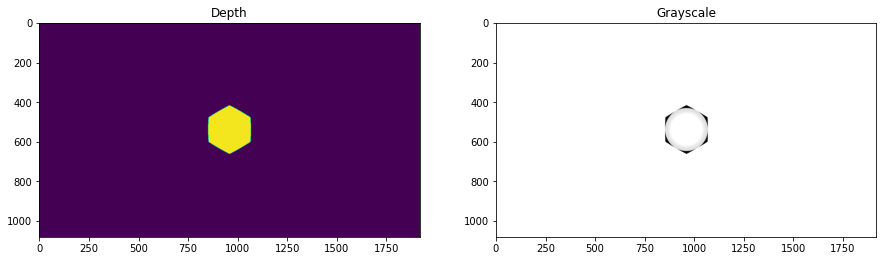

In [1]:
# read in untransformed bolt
# The untransformed location of the bolt is such that the center of the head is at 0,0,0
# and it is pointing in the direction and centered on the positive x axis.
# For example, rotating it around the z axis 90 degrees will make it appear pointing left
from utility.pose_data import get_bolt_depthimage, show_depthimage, make_pointcloud, get_random_transform
from utility.transformation_matrix import TransformationMatrix
from utility.visualizer import visualizer as vis

depthimage = get_bolt_depthimage()
show_depthimage(depthimage)

x=0.0, y=0.0, z=0.0
x_rotate=0.0°, y_rotate=0.0°, z_rotate=90.0°


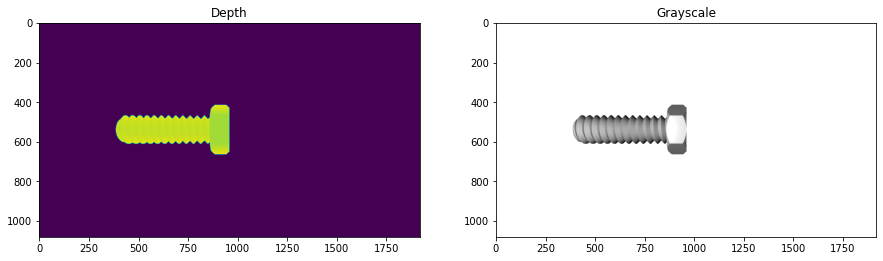

In [2]:
transform = TransformationMatrix.from_xyzwpr([0,0,0,0,0,90])
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)

x=1.59, y=2.49, z=-17.44
x_rotate=0.0°, y_rotate=-19.91°, z_rotate=0.4°


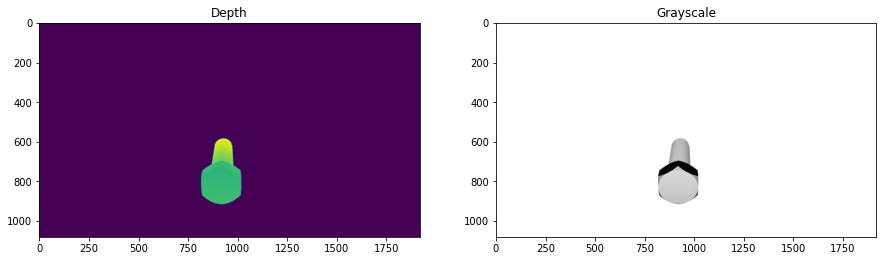

Plane equation: 0.94x + 0.01y + 0.34z + 3.22 = 0
Now I'm a point cloud. Try moving me around!
Press ctrl+c to stop (or press interrupt if in jupyter)


In [86]:
transform = get_random_transform()
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)
pcd = make_pointcloud(depthimage)

# creating PointCloud of head of bolt

plane_model, inliers = pcd.segment_plane(distance_threshold = .05, ransac_n=4, num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0,0,0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([0, 0, 1])

# end

print("Now I'm a point cloud. Try moving me around!")
vis.draw_geometries([inlier_cloud, outlier_cloud], moveable=True)

Truth
x=0.0, y=-20.0, z=0.0
x_rotate=-0.0°, y_rotate=18.0°, z_rotate=20.0°


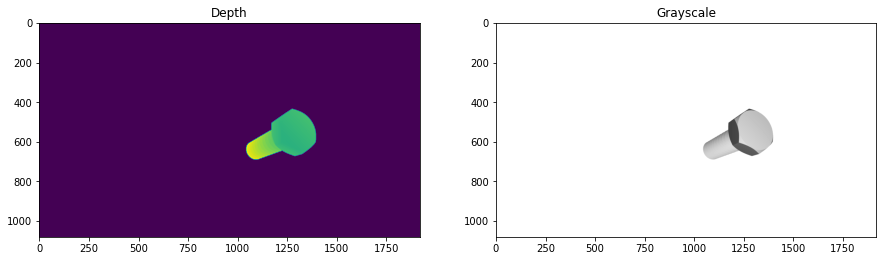

Estimate
x=0.45, y=-19.99, z=-0.02
x_rotate=0.0°, y_rotate=18.36°, z_rotate=19.33°

Error: 0.363


In [71]:
import numpy as np
from scipy.spatial.transform import Rotation as R


def rotation_between_vectors(u, v):
    # u and v are both 3D unit vectors
    axis = np.cross(u, v)
    unit = axis / np.linalg.norm(axis)
    angle = np.arccos(np.dot(u, v))
    rotvec = unit * angle
    return R.from_rotvec(rotvec)


def estimator(transformed_depthimage, debug=False):
    orig_normal = np.array([1,0,0]) # the bolt head is initially pointed in the x direction
    orig_center = np.array([0,0,0]) # the bolt head is initially centered at 0,0,0

    trns_pcd = make_pointcloud(transformed_depthimage)
    
    # we use a try catch so that if the camera is too far away from the bolt, 
    # we can catch the thrown exception and have a fallback plan
    try:
    
        # creating PointCloud of head of bolt
        plane_model, inliers = trns_pcd.segment_plane(distance_threshold = .01, ransac_n=4, num_iterations=1000)
        [a, b, c, d] = plane_model

        inlier_cloud = trns_pcd.select_by_index(inliers)
        inlier_cloud.paint_uniform_color([1.0,0,0])
        outlier_cloud = trns_pcd.select_by_index(inliers, invert=True)
        outlier_cloud.paint_uniform_color([0, 0, 1])

        # end

        
        # finding the center of the bolt head
        # we use a bounding box to find the y and z coordinates, and the average of x points 
        # for all the points in the PointCloud
        # we found this combined method to be the most accurate
        
        # trns_center = inlier_cloud.get_center()
        # trns_center = inlier_cloud.compute_mean_and_covariance()[0]
        trns_center = inlier_cloud.get_oriented_bounding_box().get_center()
        trns_center[0] = inlier_cloud.get_center()[0] # get the x center using a different method
        translation = (trns_center - orig_center)

        # ways to get the center of the bolt head
        # get max x, y, z and min x, y, z, and find the average
        # use the inlier_cloud.get_center()
        # try usig a bounding box (seems like the worse method)
        # try rotating back and finding center

        
        # getting the rotation between the original normal vector and the normal vector for the bolt
        rot = rotation_between_vectors(orig_normal, np.array([a, b, c]))
        rotvec = rot.as_rotvec()
        rotvec[0] = 0 # the rotation in x_rotate will always be 0 because I made that constraint
        rot = R.from_euler('xyz', rotvec).as_matrix()

        
        return TransformationMatrix.compose(rot, translation)
    except:
        print("Exception")
        rot = np.zeros(3) # dummy values
        rot[0] = 0 # the rotation in x_rotate will always be 0 because I made that constraint
        rot = R.from_euler('xyz', rot).as_matrix()
        trns_center = trns_pcd.get_center()
        translation = (trns_center - orig_center)
        # We assume the y coordinates are shooting above the camera/robot arm 
        # this is just a guess when we are too far away from the bolt
        translation[1] = 2500
        return TransformationMatrix.compose(rot, translation)

transform = TransformationMatrix.from_xyzwpr([0,-20,0,0,18,20]) # test matrix
print('Truth')
print(transform)
transformed = get_bolt_depthimage(transform)
transformed_pcd = make_pointcloud(transformed)


show_depthimage(transformed)
vis.draw_geometries([transformed_pcd], moveable=False)
estimate = estimator(transformed, debug=False)
print('Estimate')
print(estimate)
from utility.pose_estimation import transform_error, evaluate_random
print('\nError:', transform_error(estimate, transform).round(3))

In [72]:
# you can use this convience function to get the loss on a random transformation
evaluate_random(estimator) 

0.5227253754298787

In [6]:
import os
os.environ["DISCORD_USERNAME"] = "shrey"

In [73]:
from utility.pose_estimation import make_submission, test_images
from tqdm import tqdm

print('Estimating transformations')
estimates = np.array([estimator(img) for img in tqdm(test_images)])
make_submission(estimates)

Estimating transformations


100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 10.79it/s]


Mean rmse=0.8287
Your ranking: #37

In [74]:
from utility.scoring_client import get_highscores, get_myscores, Challenge
print(get_highscores(Challenge.POSE))

Your Ranking: #37
                           score
name                            
"kxrider"             -14.555914
'Goof Josh            -14.555914
'gust141999           -14.555914
Brigyth               -14.555914
CapnCrunch            -14.555914
Catherine Duong        -6.615265
Fxnchy                 -6.679010
Goof Josh              -6.622292
Haoshen               -14.555914
Josiah                -14.555914
Katherine_Stevens      -6.679010
Legolas                -8.393034
Mavert                 -6.632729
Robot Faust Stoneware  -6.622292
Seth Hamilton          -6.679010
Srujana               -14.555914
THANOS                -14.555914
YoungBreezy            -1.154201
ananththebunth         -6.622292
bhanu                 -14.555914
conor                  -0.604942
cz_zhao                -6.679010
danbeltran             -6.622292
fardeenmozumder        -6.475283
hieule                 -6.622292
josiah                 -6.615265
kxrider                -6.679010
marbhic                -6

In [75]:
get_myscores(Challenge.POSE)

[-0.8287167001305303,
 -0.82872887515977,
 -0.8287500867317564,
 -0.8287823316768979,
 -0.8288152942136304,
 -0.8288259960533324,
 -0.8289646538355726,
 -0.830874335893729,
 -0.8489984861328418,
 -6.679010431471446,
 -14.555913725224011,
 -14.555913725224011,
 -14.555913725224011]

# Robot Control Challenge

  1%|▍                                          | 2/200 [00:00<00:30,  6.58it/s]/var/folders/0w/xmz1v13s3xqb96zqymx5sp4w0000gn/T/ipykernel_21284/2758877040.py:146: RankWarning: Polyfit may be poorly conditioned
  prediction = getPredictionNumpy(smoothAllPositions)
100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.37it/s]
/var/folders/0w/xmz1v13s3xqb96zqymx5sp4w0000gn/T/ipykernel_21284/2758877040.py:176: RankWarning: Polyfit may be poorly conditioned
  firstlast.append(getPredictionNumpy(arr[0:i]))


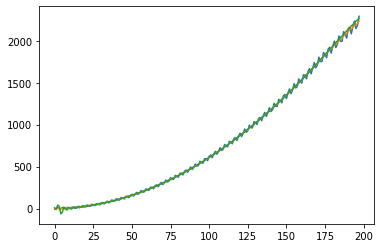

     bolt position                            robot visited positions  time  \
0            9.408  [0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3000000000000...  0.02   
1           -7.270  [7.766790187540217, 6.126035722257971, 4.48528...  0.04   
2           -2.996  [-9.000000000000004, -11.000000000000004, -13....  0.06   
3           11.403  [-25.000000000000004, -23.000000000000004, -21...  0.08   
4           -3.352  [-5.0000000000000036, -3.0000000000000036, -1....  0.10   
..             ...                                                ...   ...   
195       2234.194  [2122.858445834881, 2124.858445834881, 2126.85...  3.92   
196       2145.922  [2142.858445834881, 2144.858445834881, 2146.85...  3.94   
197       2184.063  [2158.858445834881, 2160.858445834881, 2162.85...  3.96   
198       2292.092  [2178.858445834881, 2180.858445834881, 2182.85...  3.98   
199       2223.728  [2198.858445834881, 2200.858445834881, 2202.85...  4.00   

     rewards                                       

In [87]:
from utility.remote_env import RobotorqueEnvironment
from tqdm import tqdm 

import matplotlib.pyplot as plt

from scipy.interpolate import InterpolatedUnivariateSpline

# uses first and last points to create a line and extrapolate
def getPrediction(historyOfPositions):
    # n = 0, and average of last two to predict next point
    i = len(historyOfPositions)
    # not enough data to predict
    if i == 1:
        prediction = 9
    # still not enough data
    elif i == 2:
        prediction = -6
    elif i == 3:
        slope = (historyOfPositions[1] - historyOfPositions[0]) / 2
        prediction = historyOfPositions[1] + slope
    else:
        final = (historyOfPositions[i - 2] + historyOfPositions[i - 1]) / 2
        slope = (final - historyOfPositions[0]) / (i - 1)
        prediction = historyOfPositions[i-1] + slope
    return prediction

# uses last 4 points to create linear regression
def getPrediction2(historyOfPositions):
    # n = 0, and average of last two to predict next point
    i = len(historyOfPositions)
    # not enough data to predict
    if i == 1:
        prediction = 9
    # still not enough data
    elif i == 2:
        prediction = -6
    elif i == 3:
        slope = (historyOfPositions[1] - historyOfPositions[0]) / 2
        prediction = historyOfPositions[1] + slope
    elif i == 4:
        slope = (historyOfPositions[2] - historyOfPositions[1]) / 2
        prediction = historyOfPositions[2] + slope
    else:
        final = (historyOfPositions[i - 2] + historyOfPositions[i - 1]) / 2
        initial = (historyOfPositions[i - 4] + historyOfPositions[i - 3]) / 2
        slope = (final - initial) / (2)
        prediction = historyOfPositions[i - 1] + slope
    return prediction

# tries to model oscillating behavior
def oscilatingPrediction(history):
    i = len(history)
    if i == 1:
        return 9
    elif i == 2:
        return -6
    elif i == 3:
        return 2 * history[1]
    else:
        upterm = history[i-2]
        lowterm = history[i-4]
        slope = (upterm - lowterm) / 2
        print(lowterm, upterm, slope)
        finalVal = upterm + slope * 2
        return finalVal

# uses numpy regression of degree 3 to model function
# this worked best so far
def getPredictionNumpy(history):
    if len(history) == 1:
        return 9
    elif len(history) == 2:
        return -7
    x = [i for i in range(len(history))]
    y = history
    deg = 3
    coeffs = np.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
    xstar = len(history)
    prediction = 0
    i = 0
    for coeff in coeffs[::-1]:
        prediction += coeff * xstar ** i
        i += 1
    return prediction

# tries to overestimate the value each time (just hit the high values)
def getPredictionOver(history):
    i = len(history)
    if i == 1:
        return 9
    elif i == 2:
        return -6
    elif i == 3:
        return 2 * history[1]
    elif history[i-1] < history[i-2]:
        upterm = history[i-2]
        lowterm = history[i-4]
        slope = (upterm - lowterm) / 2
        finalVal = upterm + slope * 2
        return finalVal
    else:
        upterm = history[i-1]
        lowterm = history[i-3]
        slope = (upterm - lowterm) / 2
        finalVal = upterm + slope
        return finalVal

# tries spline interpolation to model oscillating behavior and 
# general function behavior
def getPredictionScipy(history):
    if len(history) == 1:
        return 9
    elif len(history) == 2:
        return -6
    elif len(history) == 3:
        return 3
    # given values
    xi = np.array([i for i in range(len(history))])
    yi = np.array(history)
    # positions to inter/extrapolate
    x = [len(history)]
    # spline order: 1 linear, 2 quadratic, 3 cubic ... 
    order = 1
    # do inter/extrapolation
    s = InterpolatedUnivariateSpline(xi, yi, k=order)
    y = s(x)
    return y[0]

# try smoothing next

env = RobotorqueEnvironment(Challenge.ROBOT)
state = env.reset()
history = []
arr = []
allPositions = []
smoothAllPositions = []
for _ in tqdm(list(range(200))):
    allPositions.append(state['bolt_pose'].translation[1])
    # smoothing allPositions to help our function
    smoothAllPositions.append(allPositions[-1])
    numSmoothValues = 3
    if len(allPositions) > numSmoothValues:
        for i in range(1, numSmoothValues):
            smoothAllPositions[-1] += allPositions[-1 - i]
        smoothAllPositions[-1] /= numSmoothValues
    prediction = getPredictionNumpy(smoothAllPositions)
    # we steadily go to our prediction over the CONTROLS_PER_CAPTURE iterations
    prevPosition = allPositions[-1]
    incrementValue = (prediction - prevPosition) / env.CONTROLS_PER_CAPTURE
    robot_positions = [prevPosition + incrementValue]
    for i in range(1, env.CONTROLS_PER_CAPTURE):
        robot_positions.append(robot_positions[i - 1] + incrementValue)

    # print("robot positions:", robot_positions)
    state, reward, done, info = env.step(robot_positions)
    arr.append(state['bolt_pose'].translation[1])
    info['rewards'] = reward
    history.append(info)

    
# information about the location of the bolt as function
# used to graph and gain information about our models and accuracy
t = []
for i in range(0, len(arr) - 2):
    t.append(i)
smootharr = []
for i in range(1, len(arr) - 1):
    smootharr.append((arr[i - 1] + arr[i] + arr[i + 1]) / 3)
dersmooth = []
for i in range(len(smootharr)):
    dersmooth.append((smootharr[i] - smootharr[i - 1]) / 2)

# plotting where we want our robot arm to go over time
firstlast = []
for i in range(1, len(arr)):
    firstlast.append(getPredictionNumpy(arr[0:i]))
    
fig, ax = plt.subplots()
ax.plot(t, arr[1:-1])
ax.plot(t, smootharr)
#ax.plot(t, dersmooth)
ax.plot(t, firstlast[0:-1])
plt.show()

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
if done:
    print('Ranking', info['ranking'])


  1%|▍                                          | 2/200 [00:01<01:57,  1.68it/s]/var/folders/0w/xmz1v13s3xqb96zqymx5sp4w0000gn/T/ipykernel_21284/1285148564.py:41: RankWarning: Polyfit may be poorly conditioned
  prediction = getPredictionNumpy(smoothAllPositions)
 85%|██████████████████████████████████▊      | 170/200 [01:45<00:17,  1.68it/s]

Exception


 86%|███████████████████████████████████▍     | 173/200 [01:46<00:15,  1.70it/s]

Exception


 88%|████████████████████████████████████     | 176/200 [01:48<00:14,  1.67it/s]

Exception


 93%|██████████████████████████████████████▏  | 186/200 [01:54<00:08,  1.64it/s]

Exception


100%|█████████████████████████████████████████| 200/200 [02:03<00:00,  1.62it/s]


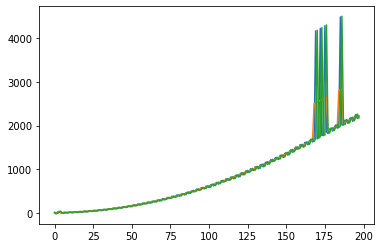

     bolt position                            robot visited positions  time  \
0            9.408  [0.8947720694756505, 1.7953529506450225, 2.695...  0.02   
1           -7.270  [7.757203676367044, 6.117514378992928, 4.47782...  0.04   
2           -2.996  [-9.0, -11.0, -13.0, -15.0, -17.0, -19.0, -21....  0.06   
3           11.403  [-25.0, -23.0, -21.0, -19.0, -17.0, -15.0, -13...  0.08   
4           -3.352  [-5.0, -3.0, -1.0, 1.0, 3.0, 5.0, 7.0, 9.0, 11...  0.10   
..             ...                                                ...   ...   
195       2234.194  [2148.3493981987713, 2150.3493981987713, 2152....  3.92   
196       2145.922  [2168.3493981987713, 2170.3493981987713, 2172....  3.94   
197       2184.063  [2185.3012595024293, 2187.3012595024293, 2189....  3.96   
198       2292.092  [2205.3012595024293, 2207.3012595024293, 2209....  3.98   
199       2223.728  [2225.3012595024293, 2227.3012595024293, 2229....  4.00   

     rewards                                       

In [83]:
import utility.remote_env as ur
from tqdm import tqdm 

import importlib
importlib.reload(ur)

import matplotlib.pyplot as plt

env = ur.RobotorqueEnvironment(Challenge.COMBINED)
state = env.reset()
history = []
arr = []
allPositions = []
smoothAllPositions = []
last_robo_pose = 0
for _ in tqdm(list(range(200))):
    boltPose = estimator(state['bolt_pose']).translation[1]
    allPositions.append(boltPose + last_robo_pose)
    
    # smoothing allPositions to help our function
    smoothAllPositions.append(allPositions[-1])
    numSmoothValues = 3
    if len(allPositions) > numSmoothValues:
        for i in range(1, numSmoothValues):
            smoothAllPositions[-1] += allPositions[-1 - i]
        smoothAllPositions[-1] /= numSmoothValues
    prediction = getPredictionNumpy(smoothAllPositions)
    # we steadily go to our prediction over the CONTROLS_PER_CAPTURE iterations
    prevPosition = allPositions[-1]
    incrementValue = (prediction - prevPosition) / env.CONTROLS_PER_CAPTURE
    robot_positions = [prevPosition + incrementValue]
    for i in range(1, env.CONTROLS_PER_CAPTURE):
        robot_positions.append(robot_positions[i - 1] + incrementValue)

    # print("robot positions:", robot_positions)
    state, reward, done, info = env.step(robot_positions)
    last_robo_pose = state['robot_pose'].translation[1]
    arr.append(boltPose + last_robo_pose)
    info['rewards'] = reward
    history.append(info)


# information about the location of the bolt as function
# we use this to plot for debugging
t = []
for i in range(0, len(arr) - 2):
    t.append(i)
smootharr = []
for i in range(1, len(arr) - 1):
    smootharr.append((arr[i - 1] + arr[i] + arr[i + 1]) / 3)
dersmooth = []
for i in range(len(smootharr)):
    dersmooth.append((smootharr[i] - smootharr[i - 1]) / 2)
    
firstlast = []
for i in range(1, len(arr)):
    firstlast.append(getPrediction(arr[0:i]))
    
fig, ax = plt.subplots()
ax.plot(t, arr[1:-1])
ax.plot(t, smootharr)
#ax.plot(t, dersmooth)
ax.plot(t, firstlast[0:-1])
plt.show()

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
if done:
    print('Ranking', info['ranking'])